# Earthquake Damage in Okhaldhunga

In [1]:
# import libraries
import warnings
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import inspect
from sqlalchemy.sql import text
from category_encoders import OneHotEncoder
from category_encoders import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
# from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
warnings.simplefilter(action="ignore", category=FutureWarning)

## Prepare Data

### Connect

In [2]:
# create database
connection = sqlite3.connect('nepal_earthquake.db')

# Create engine: engine
engine = create_engine('sqlite:////Users/Blurryface/Documents/GitHub/Data_Science_Portfolio/4_Earthequake_Prediction/nepal_earthquake.db')

# Inspect DB for list of table names
insp = inspect(engine)

# Save the table names to a list: table_names
table_names = insp.get_table_names()

# Print the table names to the shell
print(table_names)

['building_damage', 'building_structure', 'household_demo', 'mapping']


In [3]:
# Open engine in context manager
# Perform query and save results to DataFrame: df
sql = """
    SELECT DISTINCT(district_id) AS Unique_District_Id
    FROM building_damage
    LIMIT 5;
"""
with engine.connect() as conn:
    query = conn.execute(text(sql))         
df = pd.DataFrame(query.fetchall())
# Print the head of the DataFrame df
print(df.head())

   Unique_District_Id
0                  12
1                  20
2                  21
3                  22
4                  23


In [4]:
# Open engine in context manager
# Perform query and save results to DataFrame: df
sql = """
    SELECT COUNT(*) AS Number_of_Observations
    FROM building_damage
    WHERE district_id = 12;
"""
with engine.connect() as conn:
    query = conn.execute(text(sql))         
df = pd.DataFrame(query.fetchall())
# Print the head of the DataFrame df
print(df.head())

   Number_of_Observations
0                   39352


In [5]:
sql = '''
    SELECT DISTINCT(m.building_id) AS b_id, 
           s.*,
           d.damage_grade
    FROM mapping AS m
    JOIN building_structure AS s ON m.building_id = s.building_id
    JOIN building_damage AS d ON m.building_id = d.building_id
    WHERE s.district_id = 12
    LIMIT 5;
'''

with engine.connect() as conn:
    query = conn.execute(text(sql))         
df = pd.DataFrame(query.fetchall())
# Print the head of the DataFrame df
print(df.head())

           b_id  index   building_id  district_id  vdcmun_id  ward_id  \
0  120101000011      0  120101000011           12       1207   120703   
1  120101000021      1  120101000021           12       1207   120703   
2  120101000031      2  120101000031           12       1207   120703   
3  120101000041      3  120101000041           12       1207   120703   
4  120101000051      4  120101000051           12       1207   120703   

   count_floors_pre_eq  count_floors_post_eq  age_building  plinth_area_sq_ft  \
0                    1                     1             9                288   
1                    1                     1            15                364   
2                    1                     1            20                384   
3                    1                     1            20                312   
4                    1                     1            30                308   

   ...  has_superstructure_cement_mortar_brick  has_superstructure_timber 

### Import

In [6]:
def wrangle(db_path):
    
    # connect database
    conn = sqlite3.connect(db_path)
    
    # create query
    query = '''
    SELECT DISTINCT(m.building_id) AS b_id, 
           s.*,
           d.damage_grade AS damage_grade_1
    FROM mapping AS m
    JOIN building_structure AS s ON m.building_id = s.building_id
    JOIN building_damage AS d ON m.building_id = d.building_id
    WHERE s.district_id = 12
    '''
    
    # import query into dataframe
    df = pd.read_sql_query(query, conn, index_col='b_id')
    
    # reverse one hot encoding for superstructure
    super_cols = [col for col in df.columns if "has_superstructure" in col]
    df['superstructure'] = df[super_cols].idxmax(1).str[19:]
    
    # Create binary target column
    df["damage_grade_1"] = df["damage_grade_1"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade_1"] > 3).astype(int)
    
    # Identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]
    drop_cols = drop_cols + super_cols
    drop_cols.append("technical_solution_proposed")

    
    # Add high-cardinality / redundant column
    drop_cols.append("building_id")
    drop_cols.append("index")
    drop_cols.append("district_id")
    drop_cols.append("vdcmun_id")
    drop_cols.append("ward_id")
    
    # Drop old target
    drop_cols.append("damage_grade_1")
    drop_cols.append("damage_grade")

    
    # Drop multicollinearity column
    drop_cols.append("count_floors_pre_eq")
    
    # Drop columns
    df.drop(columns=drop_cols, inplace=True)

    return df

In [7]:
# run wrangle function, assign to df
df = wrangle("/Users/Blurryface/Documents/GitHub/Data_Science_Portfolio/4_Earthequake_Prediction/nepal_earthquake.db")
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
120101000011,9,288,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,mud_mortar_stone,0
120101000021,15,364,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,mud_mortar_stone,1
120101000031,20,384,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,mud_mortar_stone,0
120101000041,20,312,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,mud_mortar_stone,0
120101000051,30,308,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,mud_mortar_stone,0


### Explore

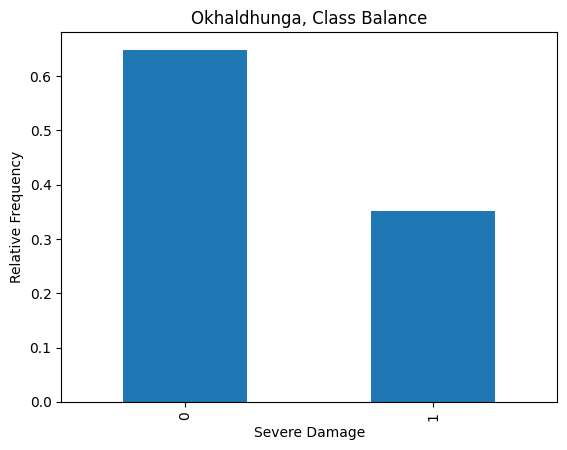

In [8]:
# Plot value counts of `"severe_damage"`
df.severe_damage.value_counts(normalize=True).plot(kind='bar')
plt.xlabel('Severe Damage')
plt.ylabel('Relative Frequency')
plt.title('Okhaldhunga, Class Balance');

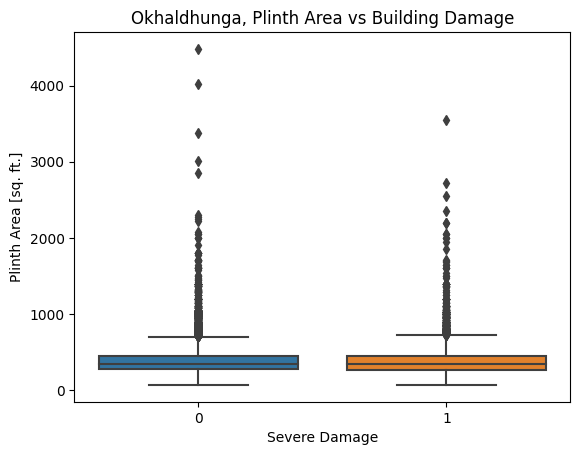

In [9]:
# plot boxplot
sns.boxplot(x="severe_damage", y="plinth_area_sq_ft", data=df)
plt.xlabel('Severe Damage')
plt.ylabel('Plinth Area [sq. ft.]')
plt.title('Okhaldhunga, Plinth Area vs Building Damage');

In [10]:
# define major and minor classes
majority_class_prop, minority_class_prop = df["severe_damage"].value_counts(normalize=True)
print(majority_class_prop, minority_class_prop)

0.6483208162108545 0.35167918378914553


In [11]:
# create pivot table for roof_type
roof_pivot = pd.pivot_table(
        df, index="roof_type", values="severe_damage", aggfunc=np.mean
).sort_values(by="severe_damage")
roof_pivot

,severe_damage
roof_type,
RCC/RB/RBC,0.032086
Bamboo/Timber-Light roof,0.296803
Bamboo/Timber-Heavy roof,0.498982


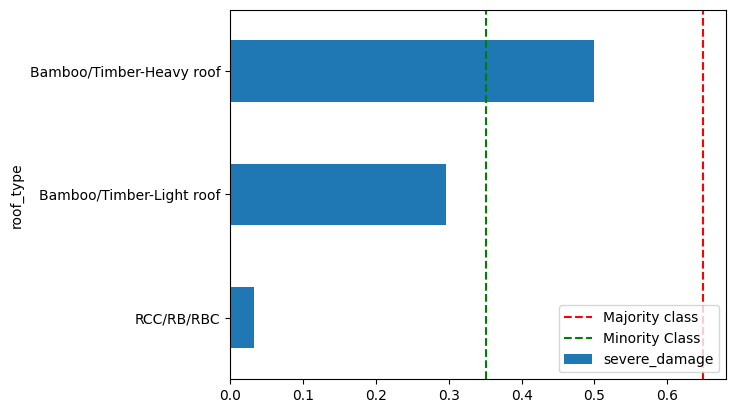

In [12]:
# Plot bar chart of `foundation_pivot`
roof_pivot.plot(kind="barh", legend=None)
plt.axvline(
    majority_class_prop, linestyle="--", color='red', label='Majority class'
)
plt.axvline(
    minority_class_prop, linestyle="--", color='green', label = 'Minority Class'
)
plt.legend(loc='lower right');

In [13]:
# create pivot table for foundatation_type
foundation_pivot = pd.pivot_table(
        df, index="foundation_type", values="severe_damage", aggfunc=np.mean
).sort_values(by="severe_damage")
foundation_pivot

,severe_damage
foundation_type,
RC,0.000000
Other,0.115942
Bamboo/Timber,0.119508
Cement-Stone/Brick,0.353308
Mud mortar-Stone/Brick,0.357715


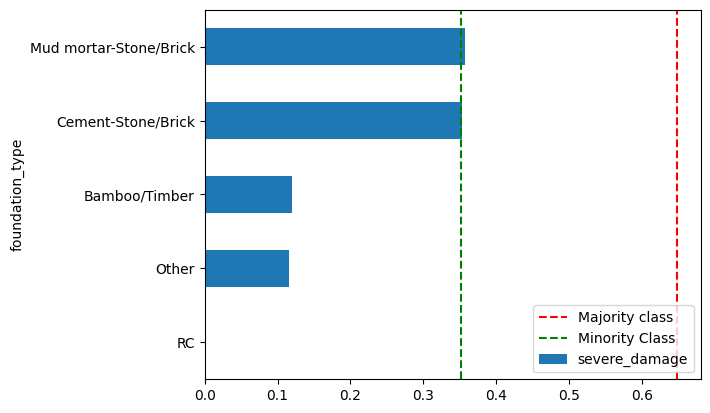

In [14]:
# Plot bar chart of `foundation_pivot`
foundation_pivot.plot(kind="barh", legend=None)
plt.axvline(
    majority_class_prop, linestyle="--", color='red', label='Majority class'
)
plt.axvline(
    minority_class_prop, linestyle="--", color='green', label = 'Minority Class'
)
plt.legend(loc='lower right');

### Split

In [15]:
# create taget variable and feature variables
target = 'severe_damage'
X = df.drop(columns=target)
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (35285, 11)
y shape: (35285,)


In [16]:
# create training and validation data
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (28228, 11)
y_train shape: (28228,)
X_val shape: (7057, 11)
y_val shape: (7057,)


## Build Model

### Baseline

In [17]:
# determine baseline accuracy
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.65


### Iterate

In [18]:
# create logistic regression model
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=3000)
)
model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=3000))])

In [19]:
# determine training and validation accuracy score for lr model
lr_train_acc = model_lr.score(X_train,y_train)
lr_val_acc = model_lr.score(X_val,y_val)

print("Logistic Regression, Training Accuracy Score:", lr_train_acc)
print("Logistic Regression, Validation Accuracy Score:", lr_val_acc)

Logistic Regression, Training Accuracy Score: 0.6628524868924472
Logistic Regression, Validation Accuracy Score: 0.6631713192574749


In [20]:
# define range of max_depth parameter
depth_hyperparams = range(1, 16)
# create lists to contain accuracy scores at each depth
training_acc = []
validation_acc = []
# iterate through depths
for d in depth_hyperparams:
    # create pipeline
    model_dt = make_pipeline(
        OrdinalEncoder(),
        DecisionTreeClassifier(max_depth=d, random_state=42)
    )
    # fit model
    model_dt.fit(X_train, y_train)
    training_acc.append(model_dt.score(X_train,y_train))
    validation_acc.append(model_dt.score(X_val,y_val))
    
print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])

Training Accuracy Scores: [0.646946294459402, 0.6600184214255349, 0.6600184214255349]
Validation Accuracy Scores: [0.6538189032166644, 0.6675641207311889, 0.6675641207311889]


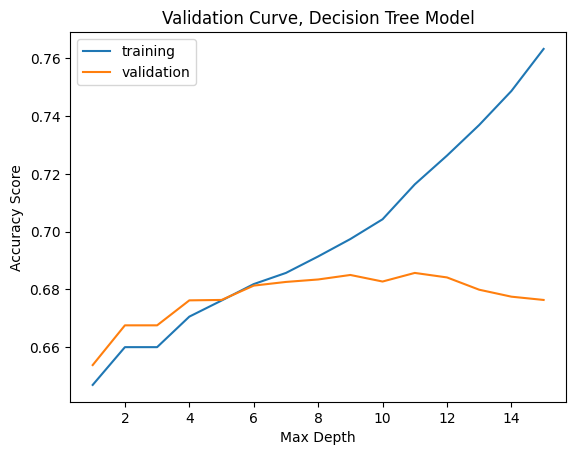

In [21]:
# plot validation curve of dt model
plt.plot(depth_hyperparams, training_acc, label="training")
plt.plot(depth_hyperparams, validation_acc, label="validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.title("Validation Curve, Decision Tree Model")
plt.legend();

In [22]:
# create best model for dt classifier with best depth
final_model_dt = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(max_depth=11, random_state=42)
)
final_model_dt.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
Building with Central Courtyard     9
H-shape                            10
NaN                                -2
dtype: int64},
                                         {'col': 'superstructure',
                                          'data_type': dtype('O'),
                                          'mapping': mud_mortar_stone        1
adobe_mud               2
bamboo                  3
cement_mortar_stone     4
timber                  5
other                   6
cement_mortar_brick     7
rc_non_engineered       8
rc_engineered           9
mud_mortar_brick       10
stone_flag             11
NaN                    -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=11, random_state=42))])

In [23]:
# determine training and validation accuracy score for dt classifier
dt_train_acc = final_model_dt.score(X_train,y_train)
dt_val_acc = final_model_dt.score(X_val,y_val)

print("Decision Tree, Training Accuracy Score:", dt_train_acc)
print("Decision Tree, Validation Accuracy Score:", dt_val_acc)

Decision Tree, Training Accuracy Score: 0.7163454725804166
Decision Tree, Validation Accuracy Score: 0.6857021397194275


### Evaluate

In [24]:
# evaluate model performance on test data
X_test = pd.read_csv("data/kavrepalanchok-test-features.csv", index_col="b_id")
# predict whether building will be serverly damaged or not
y_test_pred = final_model_dt.predict(X_test)
y_test_pred[:5]

array([0, 0, 0, 1, 0])

## Communicate Results

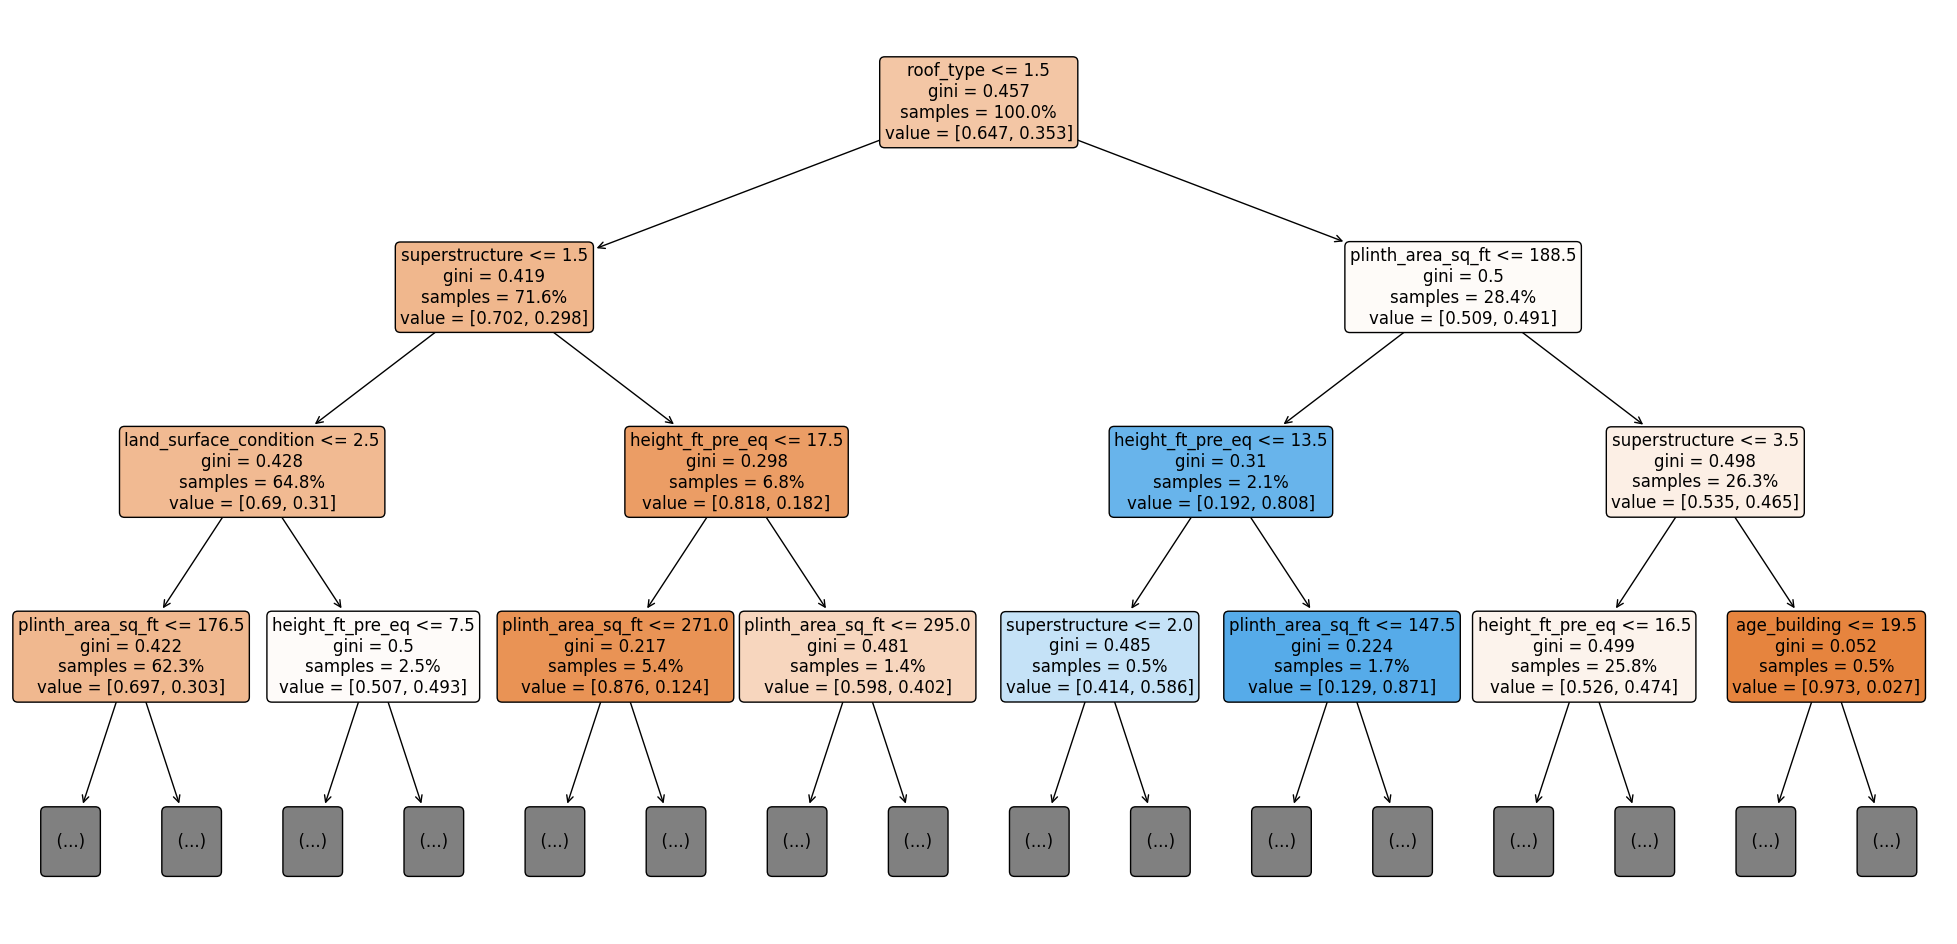

In [25]:
# Create larger figure
fig, ax = plt.subplots(figsize=(25, 12))
# Plot tree
plot_tree(
    decision_tree=final_model_dt.named_steps['decisiontreeclassifier'],
    feature_names=X_train.columns,
    filled=True,  # Color leaf with class
    rounded=True,  # Round leaf edges
    proportion=True,  # Display proportion of classes in leaf
    max_depth=3,  # Only display first 3 levels
    fontsize=12,  # Enlarge font
    ax=ax,  # Place in figure axis
);

In [26]:
# assign features
features = X_train.columns
# get gini importance
importances = final_model_dt.named_steps['decisiontreeclassifier'].feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.head()

plan_configuration    0.009516
foundation_type       0.010853
position              0.011210
ground_floor_type     0.034884
other_floor_type      0.038078
dtype: float64

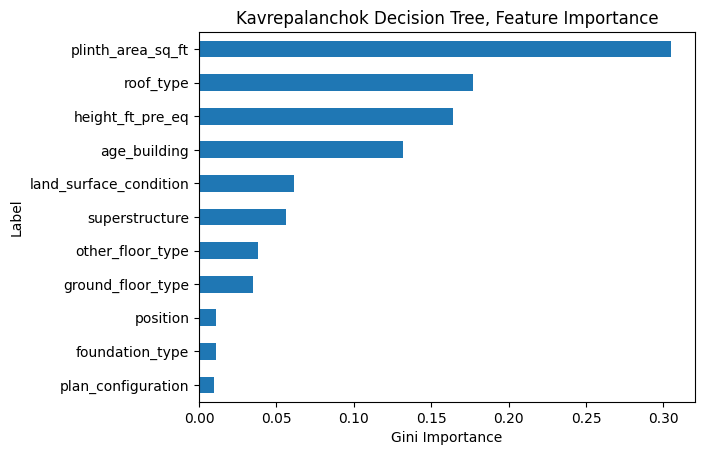

In [27]:
# Create horizontal bar chart of feature importances
feat_imp.plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Label')
plt.title("Kavrepalanchok Decision Tree, Feature Importance");


## Deployment


In [28]:
# define prediction function
def make_prediction(
    age_building, 
    plinth_area_sq_ft, 
    height_ft, 
    land_surface_condition, 
    foundation_type, 
    roof_type,
    ground_floor_type,
    other_floor_type,
    position,
    plan_configuration,
    superstructure
    ):
    data = {
        'age_building': age_building,
        'plinth_area_sq_ft': plinth_area_sq_ft,
        'height_ft_pre_eq': height_ft,
        'land_surface_condition': land_surface_condition,
        'foundation_type': foundation_type,
        'roof_type': roof_type,
        'ground_floor_type': ground_floor_type,
        'other_floor_type': other_floor_type,
        'position': position,
        'plan_configuration': plan_configuration,
        'superstructure': superstructure
    }
    df = pd.DataFrame(data, index=[0])
    prediction = final_model_dt.predict(df)
    
    if prediction == 1:
        print("Your building is at risk of suffering severe damage during an earthquake")
    else:
        print("Your building is not at risk of suffering severe damage during an earthquake")


In [29]:
# create interactive dashboard
interact(
    make_prediction,
    age_building=IntSlider(
        min=X_train["age_building"].min(),
        max=X_train["age_building"].max(),
        step=1,
        value=X_train["age_building"].mean(),
    ),
    plinth_area_sq_ft=FloatSlider(
        min=X_train["plinth_area_sq_ft"].min(),
        max=X_train["plinth_area_sq_ft"].max(),
        step = 0.01,
        value=X_train["plinth_area_sq_ft"].mean(),
    ),
    height_ft=FloatSlider(
        min=X_train["height_ft_pre_eq"].min(),
        max=X_train["height_ft_pre_eq"].max(),
        step = 0.01,
        value=X_train["height_ft_pre_eq"].mean(),
    ),
    land_surface_condition=Dropdown(options=sorted(
        X_train['land_surface_condition'].astype(str).unique())
    ),
    foundation_type=Dropdown(options=sorted(
        X_train['foundation_type'].astype(str).unique())
    ),
    roof_type=Dropdown(options=sorted(
        X_train['roof_type'].astype(str).unique())
    ),
    ground_floor_type=Dropdown(options=sorted(
        X_train['ground_floor_type'].astype(str).unique())
    ),
    other_floor_type=Dropdown(options=sorted(
        X_train['other_floor_type'].astype(str).unique())
    ),
    position=Dropdown(options=sorted(
        X_train['position'].astype(str).unique())
    ),
    plan_configuration=Dropdown(options=sorted(
        X_train['plan_configuration'].astype(str).unique())
    ),
    superstructure=Dropdown(options=sorted(
        X_train['superstructure'].astype(str).unique())),
);

interactive(children=(IntSlider(value=20, description='age_building', max=999), FloatSlider(value=381.51328468…